In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# Python version: 3.6


import os
import copy
import time
import pickle
import numpy as np
from tqdm import tqdm

import torch
from tensorboardX import SummaryWriter

from options import args_parser
from update import LocalUpdate, test_inference
from models import MLP, CNNMnist, CNNFashion_Mnist, CNNCifar
from utils import get_dataset, average_weights, exp_details

In [18]:
import argparse

parser = argparse.ArgumentParser()
# parser.add_argument('--name', '-n', default='foo', help='foo')
parser.add_argument('--model', type=str, default='mlp', help='model name(mlp or cnn)')
parser.add_argument('--dataset', type=str, default='mnist', help="name of dataset(mnist or cifar)")
parser.add_argument('--epochs', type=int, default=1, help="number of rounds of training(10)")
parser.add_argument('--num_users', type=int, default=100, help="number of users: K")
parser.add_argument('--num_classes', type=int, default=10, help="number of classes")
parser.add_argument('--gpu', default=None, help="To use cuda, set to a specific GPU ID. Default set to use CPU.")
parser.add_argument('--frac', type=float, default=0.1, help='the fraction of clients: C')
parser.add_argument('--local_ep', type=int, default=2, help="the number of local epochs: E")
parser.add_argument('--local_bs', type=int, default=10, help="local batch size: B")
parser.add_argument('--lr', type=float, default=0.01, help='learning rate')
parser.add_argument('--optimizer', type=str, default='sgd', help="type of optimizer")
parser.add_argument('--verbose', type=int, default=1, help='verbose')
parser.add_argument('--iid', type=int, default=1, help='Default set to IID. Set to 0 for non-IID.')
parser.add_argument('--unequal', type=int, default=0, help='whether to use unequal data splits for  \
                        non-i.i.d setting (use 0 for equal splits)')
# parser.add_argument('--seed', type=int, default=1, help='random seed')

parser.add_argument('--num_clusters', type=int, default=2, help='verbose')
parser.add_argument('--test_acc', type=int, default=75, help='target test accuracy')


# args = parser.parse_args([])
args, _ = parser.parse_known_args()

args
# --dataset=mnist --gpu=0 --iid=0 --epochs=10

Namespace(dataset='mnist', epochs=1, frac=0.1, gpu=None, iid=1, local_bs=10, local_ep=2, lr=0.01, model='mlp', num_classes=10, num_clusters=2, num_users=100, optimizer='sgd', test_acc=75, unequal=0, verbose=1)

In [3]:
# if __name__ == '__main__':
start_time = time.time()
print("start time: ", start_time)

# define paths
path_project = os.path.abspath('..')
logger = SummaryWriter('../logs')

# args = args_parser()
# exp_details(args)

start time:  1571463621.1454628


In [4]:
if args.gpu:
    torch.cuda.set_device(args.gpu)
device = 'cuda' if args.gpu else 'cpu'

In [5]:
# load dataset and user groups
train_dataset, test_dataset, user_groups = get_dataset(args)

In [6]:
# Splitting into clusters. FL groups
cluster_size = args.num_users / args.num_clusters
print("Each cluster size: ", cluster_size)

# Cluster 1
A1 = np.arange(cluster_size, dtype=int)
user_groupsA = {k:user_groups[k] for k in A1 if k in user_groups}
print("Size of cluster 1: ", len(user_groupsA))
# Cluster 2
B1 = np.arange(cluster_size, cluster_size+cluster_size, dtype=int)
user_groupsB = {k:user_groups[k] for k in B1 if k in user_groups}
print("Size of cluster 2: ", len(user_groupsB))

Each cluster size:  50.0
Size of cluster 1:  50
Size of cluster 2:  50


In [7]:
# Check that clusters are all different
print(user_groupsA.keys())
print(user_groupsB.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])
dict_keys([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])


In [8]:
# BUILD MODEL
def build_model(args, train_dataset):
    if args.model == 'cnn':
        # Convolutional neural network
        if args.dataset == 'mnist':
            global_model = CNNMnist(args=args)
        elif args.dataset == 'fmnist':
            global_model = CNNFashion_Mnist(args=args)
        elif args.dataset == 'cifar':
            global_model = CNNCifar(args=args)

    elif args.model == 'mlp':
        # Multi-layer preceptron
        img_size = train_dataset[0][0].shape
        len_in = 1
        for x in img_size:
            len_in *= x
            global_model = MLP(dim_in=len_in, dim_hidden=200,
                               dim_out=args.num_classes)
    else:
        exit('Error: unrecognized model')
        
    return global_model

In [9]:
# MODEL PARAM SUMMARY
global_model = build_model(args, train_dataset)
pytorch_total_params = sum(p.numel() for p in global_model.parameters())
print(pytorch_total_params)

from torchsummary import summary

summary(global_model, (1, 28, 28))
global_model.parameters()

199210
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]         157,000
           Dropout-2                  [-1, 200]               0
              ReLU-3                  [-1, 200]               0
            Linear-4                  [-1, 200]          40,200
           Dropout-5                  [-1, 200]               0
              ReLU-6                  [-1, 200]               0
            Linear-7                   [-1, 10]           2,010
           Softmax-8                   [-1, 10]               0
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.76
Estimated Total Size (MB): 0.77
----------------------------------------------------------------


<generator object Module.parameters at 0x7fd6ae6927c8>

In [10]:
# Set the model to train and send it to device.
global_model.to(device)
global_model.train()
print(global_model)

# copy weights
global_weights = global_model.state_dict()

MLP(
  (layer_input): Linear(in_features=784, out_features=200, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (layer_hidden1): Linear(in_features=200, out_features=200, bias=True)
  (layer_hidden2): Linear(in_features=200, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [11]:
# Set the cluster models to train and send it to device.
cluster_modelA = build_model(args, train_dataset)
cluster_modelA.to(device)
cluster_modelA.train()
# copy weights
cluster_modelA_weights = cluster_modelA.state_dict()

# Set the cluster models to train and send it to device.
cluster_modelB = build_model(args, train_dataset)
cluster_modelB.to(device)
cluster_modelB.train()
# copy weights
cluster_modelB_weights = cluster_modelA.state_dict()

In [12]:
# Defining the training function
def fl_train(args, train_dataset, cluster_global_model, cluster, usergrp, epochs):
#     print(args)
    
#     # Set the model to train and send it to device.
#     cluster_global_model = build_model(args, train_dataset)
#     cluster_global_model.to(device)
#     cluster_global_model.train()

#     # copy weights
#     cluster_global_weights = cluster_global_model.state_dict()
        
    cluster_train_loss, cluster_train_accuracy = [], []
    cluster_val_acc_list, cluster_net_list = [], []
    cluster_cv_loss, cluster_cv_acc = [], []
#     print_every = 1
    cluster_val_loss_pre, counter = 0, 0
    
#     for epoch in tqdm(range(epochs)):
    for epoch in range(epochs):
        cluster_local_weights, cluster_local_losses = [], []
#         print(f'\n | Cluster Training Round : {epoch+1} |\n')

        cluster_global_model.train()
        m = max(int(args.frac * len(cluster)), 1)
        idxs_users = np.random.choice(cluster, m, replace=False)


        for idx in idxs_users:
            cluster_local_model = LocalUpdate(args=args, dataset=train_dataset, idxs=usergrp[idx], logger=logger)
            cluster_w, cluster_loss = cluster_local_model.update_weights(model=copy.deepcopy(cluster_global_model), global_round=epoch)
            cluster_local_weights.append(copy.deepcopy(cluster_w))
            cluster_local_losses.append(copy.deepcopy(cluster_loss))
            print('| Global Round : {} | User : {} | \tLoss: {:.6f}'.format(epoch, idx, cluster_loss))
            
        # averaging global weights
        cluster_global_weights = average_weights(cluster_local_weights)

        # update global weights
        cluster_global_model.load_state_dict(cluster_global_weights)

        cluster_loss_avg = sum(cluster_local_losses) / len(cluster_local_losses)
        cluster_train_loss.append(cluster_loss_avg)

#         # Calculate avg training accuracy over all users at every epoch
#         cluster_list_acc, cluster_list_loss = [], []
#         cluster_global_model.eval()
        
#         for c in range(len(cluster)):
#             cluster_local_model = LocalUpdate(args=args, dataset=train_dataset,
#                                       idxs=usergrp[idx], logger=logger)
#             cluster_acc, cluster_loss = cluster_local_model.inference(model=cluster_global_model)
#             cluster_list_acc.append(cluster_acc)
#             cluster_list_loss.append(cluster_loss)
#         cluster_train_accuracy.append(sum(cluster_list_acc)/len(cluster_list_acc))
    
#     return cluster_global_model, cluster_train_loss #cluster_global_weights, cluster_loss_avg, cluster_train_accuracy 
    return cluster_global_weights, cluster_loss_avg
    
# A_model, A_weights, A_losses, A_trainacc = fl_train(args, train_dataset, cluster_modelA, A1, user_groupsA, 2)    
# A_model, A_trainloss = fl_train(args, train_dataset, cluster_modelA, A1, user_groupsA, 2)
# A_weights, A_losses = fl_train(args, train_dataset, cluster_modelA, A1, user_groupsA, 2)

### Main training

In [19]:
train_loss, train_accuracy = [], []
val_acc_list, net_list = [], []
cv_loss, cv_acc = [], []
print_every = 1
val_loss_pre, counter = 0, 0
# Add
testacc_check, epoch = 0, 0

# for epoch in tqdm(range(args.epochs)):
while testacc_check < args.test_acc:
    local_weights, local_losses, local_accuracies= [], [], []
    print(f'\n | Global Training Round : {epoch+1} |\n')
    
    # ============== TRAIN ==============
    global_model.train()
    
    # Cluster A
    A_weights, A_losses = fl_train(args, train_dataset, cluster_modelA, A1, user_groupsA, 2)
    local_weights.append(copy.deepcopy(A_weights))
    local_losses.append(copy.deepcopy(A_losses))
    
    # Cluster B
    B_weights, B_losses = fl_train(args, train_dataset, cluster_modelB, B1, user_groupsB, 2)
    local_weights.append(copy.deepcopy(B_weights))
    local_losses.append(copy.deepcopy(B_losses))
    
    
    # averaging global weights
    global_weights = average_weights(local_weights)

    # update global weights
    global_model.load_state_dict(global_weights)

    loss_avg = sum(local_losses) / len(local_losses)
    train_loss.append(loss_avg)
    
    # ============== EVAL ============== 
    # Calculate avg training accuracy over all users at every epoch
    list_acc, list_loss = [], []
    global_model.eval()
    for c in range(args.num_users):
        local_model = LocalUpdate(args=args, dataset=train_dataset,
                                  idxs=user_groups[c], logger=logger)
        acc, loss = local_model.inference(model=global_model)
        list_acc.append(acc)
        list_loss.append(loss)
    train_accuracy.append(sum(list_acc)/len(list_acc))
    # Add
    testacc_check = 100*train_accuracy[-1] 
    
    epoch = epoch + 1
    # print global training loss after every 'i' rounds
    if (epoch+1) % print_every == 0:
#         print(f' \nAvg Training Stats after {epoch+1} global rounds:')
        print(f"\nAvg Training Stats after {epoch} global rounds:")
        print(f'Training Loss : {np.mean(np.array(train_loss))}')
        print('Train Accuracy: {:.2f}% \n'.format(100*train_accuracy[-1]))
#         print('Train Accuracy: {:.2f}% \n'.format(100*train_accuracy[-1][0]))
    

print('\n Total Run Time: {0:0.4f}'.format(time.time()-start_time))


 | Global Training Round : 1 |

| Global Round : 0 | User : 6 | 	Loss: -0.419617
| Global Round : 0 | User : 10 | 	Loss: -0.439680
| Global Round : 0 | User : 11 | 	Loss: -0.442160
| Global Round : 0 | User : 7 | 	Loss: -0.426526
| Global Round : 0 | User : 35 | 	Loss: -0.420803
| Global Round : 1 | User : 25 | 	Loss: -0.502708
| Global Round : 1 | User : 13 | 	Loss: -0.466433
| Global Round : 1 | User : 7 | 	Loss: -0.489634
| Global Round : 1 | User : 8 | 	Loss: -0.457601
| Global Round : 1 | User : 22 | 	Loss: -0.475997
| Global Round : 0 | User : 80 | 	Loss: -0.458303
| Global Round : 0 | User : 74 | 	Loss: -0.437814
| Global Round : 0 | User : 96 | 	Loss: -0.434021
| Global Round : 0 | User : 78 | 	Loss: -0.446014
| Global Round : 0 | User : 60 | 	Loss: -0.455579
| Global Round : 1 | User : 84 | 	Loss: -0.485178
| Global Round : 1 | User : 57 | 	Loss: -0.489102
| Global Round : 1 | User : 65 | 	Loss: -0.483285
| Global Round : 1 | User : 76 | 	Loss: -0.514700
| Global Round : 1 | 

| Global Round : 1 | User : 29 | 	Loss: -0.677642
| Global Round : 1 | User : 23 | 	Loss: -0.661187
| Global Round : 1 | User : 9 | 	Loss: -0.698248
| Global Round : 1 | User : 10 | 	Loss: -0.683566
| Global Round : 1 | User : 40 | 	Loss: -0.689060
| Global Round : 0 | User : 63 | 	Loss: -0.712268
| Global Round : 0 | User : 95 | 	Loss: -0.712332
| Global Round : 0 | User : 54 | 	Loss: -0.722107
| Global Round : 0 | User : 60 | 	Loss: -0.715822
| Global Round : 0 | User : 86 | 	Loss: -0.704111
| Global Round : 1 | User : 61 | 	Loss: -0.729180
| Global Round : 1 | User : 92 | 	Loss: -0.721920
| Global Round : 1 | User : 97 | 	Loss: -0.740210
| Global Round : 1 | User : 87 | 	Loss: -0.721282
| Global Round : 1 | User : 77 | 	Loss: -0.747584

Avg Training Stats after 8 global rounds:
Training Loss : -0.6139353413183319
Train Accuracy: 72.92% 


 | Global Training Round : 9 |

| Global Round : 0 | User : 37 | 	Loss: -0.711550
| Global Round : 0 | User : 49 | 	Loss: -0.683941
| Global Round

In [20]:
# Test inference after completion of training
test_acc, test_loss = test_inference(args, global_model, test_dataset)

print(f' \n Results after {args.epochs} global rounds of training:')
print("|---- Avg Train Accuracy: {:.2f}%".format(100*train_accuracy[-1]))
print("|---- Test Accuracy: {:.2f}%".format(100*test_acc))

# Saving the objects train_loss and train_accuracy:
file_name = '../save/objects/{}_{}_{}_C[{}]_iid[{}]_E[{}]_B[{}].pkl'.\
    format(args.dataset, args.model, epoch, args.frac, args.iid,
           args.local_ep, args.local_bs)

with open(file_name, 'wb') as f:
    pickle.dump([train_loss, train_accuracy], f)



 
 Results after 1 global rounds of training:
|---- Avg Train Accuracy: 75.03%
|---- Test Accuracy: 75.53%


In [24]:
# file_load = "../save/objects/mnist_mlp_1_C[0.1]_iid[1]_E[2]_B[10].pkl"
# data = pickle.load(file_load)
# mnist_mlp_1_C[0.1]_iid[1]_E[2]_B[10]
with open(r"../save/objects/mnist_mlp_14_C[0.1]_iid[1]_E[2]_B[10].pkl", "rb") as input_file:
        data = pickle.load(input_file)
        
print(data)
trloss = data[0]
tracc = data[1]

[[-0.4856552318437025, -0.5570248828657592, -0.5989704412563394, -0.6019713612428557, -0.6255851818326239, -0.6620824521562705, -0.6732053142040967, -0.7069878651450078, -0.7210720005755622, -0.7235093835430841, -0.7297830127800504, -0.7412758812618752, -0.736920749489218, -0.7510127073464294], [0.6280000000000002, 0.6428333333333337, 0.6485000000000002, 0.6525000000000002, 0.6551666666666666, 0.6911666666666669, 0.7275, 0.7291666666666665, 0.7293333333333333, 0.7343333333333333, 0.7386666666666666, 0.7395, 0.7421666666666669, 0.7503333333333332]]


/home/wesleyjtann/miniconda3/envs/fl_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  after removing the cwd from sys.path.


<function matplotlib.pyplot.show(*args, **kw)>

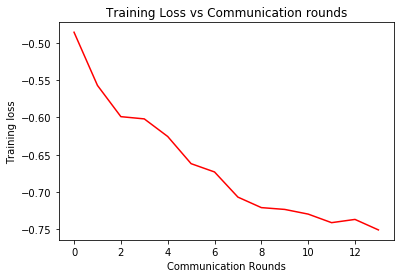

In [26]:
# PLOTTING (optional)
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')

# Plot Loss curve
plt.figure()
plt.title('Training Loss vs Communication rounds')
# plt.plot(range(len(train_loss)), train_loss, color='r')
plt.plot(range(len(trloss)), trloss, color='r')
plt.ylabel('Training loss')
plt.xlabel('Communication Rounds')
# plt.savefig('../save/fed_{}_{}_{}_C[{}]_iid[{}]_E[{}]_B[{}]_loss.png'.
#             format(args.dataset, args.model, args.epochs, args.frac,
#                    args.iid, args.local_ep, args.local_bs))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

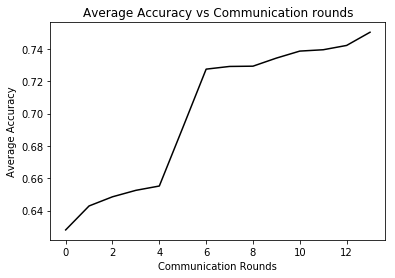

In [27]:
# Plot Average Accuracy vs Communication rounds
plt.figure()
plt.title('Average Accuracy vs Communication rounds')
# plt.plot(range(len(train_accuracy)), train_accuracy, color='k')
plt.plot(range(len(tracc)), tracc, color='k')
plt.ylabel('Average Accuracy')
plt.xlabel('Communication Rounds')
# plt.savefig('../save/fed_{}_{}_{}_C[{}]_iid[{}]_E[{}]_B[{}]_acc.png'.
#             format(args.dataset, args.model, args.epochs, args.frac,
#                    args.iid, args.local_ep, args.local_bs))
plt.show